In [1]:
import pandas as pd
import sys
import argparse
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import os
import numpy as np
import glob
import traceback
import re
from pathlib import Path

In [17]:
all_events_path = r"D:\Box Sync\Box Sync\00_BEAR_Lab\Projects\Kyler(Kihun) Hong\1st_Haptic Sleeve\PilotExperiment\MotorLearning\20251202_SNFH06_Session1\SNHF06_Session1_events.csv"
events_df = pd.read_csv(all_events_path)

def trial_timestamps(df, trial_col="trial", event_col="event", time_col="ros_time"):
    out = []

    for trial, g in df.groupby(trial_col, sort=False):
        g = g.sort_values(time_col)

        share_times = g.loc[g[event_col] == "share_button", time_col]
        rec_times   = g.loc[g[event_col] == "start_recording", time_col]
        sq_times    = g.loc[g[event_col] == "square_button", time_col]

        # start: prefer share_button, else start_recording
        if len(share_times) > 0:
            start_time = share_times.iloc[0]
        elif len(rec_times) > 0:
            start_time = rec_times.iloc[0]
        else:
            start_time = pd.NA

        # end: take the LAST square_button after start_time (fallback: last square_button)
        if len(sq_times) == 0:
            end_time = pd.NA
        else:
            if pd.isna(start_time):
                end_time = sq_times.iloc[-1]
            else:
                after = sq_times[sq_times >= start_time]
                end_time = after.iloc[-1] if len(after) > 0 else sq_times.iloc[-1]

        out.append({trial_col: trial, "start_time": start_time, "end_time": end_time})

    return pd.DataFrame(out)

# Example usage (edit trial_col if yours is "trial_number" etc.)
ts = trial_timestamps(events_df, trial_col="trial")
print(ts.to_string(index=False, float_format=lambda x: f"{x:.6f}"))

# If you want to append these times onto every row in events_df:
events_df_with_times = events_df.merge(ts, on="trial", how="left")


 trial        start_time          end_time
     0 1764694205.994672 1764694460.634227
     1 1764694490.434961 1764694627.881043
     2 1764694765.979226 1764695012.803000
     3 1764695036.439461 1764695226.870298
     4 1764695253.090887              <NA>
     5 1764695368.565682 1764695571.898882
     6 1764695599.007145 1764695856.291564
     7 1764695890.860445 1764696035.780971
     8 1764696067.981101              <NA>
     9 1764696149.357975 1764696331.611730
    10 1764696354.063863 1764696488.717341
    11 1764696511.521420 1764696627.471050
    12 1764696646.382939 1764696773.932379
    13 1764696794.245437 1764696908.762048
    14 1764696929.466698 1764697014.395440
    15 1764697037.760031 1764697152.169045
    16 1764697178.837310 1764697305.427010
    17 1764697335.399118 1764697437.188038
    18 1764697458.408064 1764697565.896848
    19 1764697585.288554 1764697683.297583
    20 1764697708.657534 1764697837.322418
    21 1764697859.846613 1764697945.431386
    22 1764

In [17]:
all_events_path2 = r"D:\Box Sync\Box Sync\00_BEAR_Lab\Projects\Kyler(Kihun) Hong\1st_Haptic Sleeve\PilotExperiment\MotorLearning\20251203_SNFH06_Session2\SNHF06_Session2_events.csv"
events_df = pd.read_csv(all_events_path2)

def trial_timestamps(df, trial_col="trial", event_col="event", time_col="ros_time"):
    out = []

    for trial, g in df.groupby(trial_col, sort=False):
        g = g.sort_values(time_col)

        share_times = g.loc[g[event_col] == "share_button", time_col]
        rec_times   = g.loc[g[event_col] == "start_recording", time_col]
        sq_times    = g.loc[g[event_col] == "square_button", time_col]

        # start: prefer share_button, else start_recording
        if len(share_times) > 0:
            start_time = share_times.iloc[0]
        elif len(rec_times) > 0:
            start_time = rec_times.iloc[0]
        else:
            start_time = pd.NA

        # end: take the LAST square_button after start_time (fallback: last square_button)
        if len(sq_times) == 0:
            end_time = pd.NA
        else:
            if pd.isna(start_time):
                end_time = sq_times.iloc[-1]
            else:
                after = sq_times[sq_times >= start_time]
                end_time = after.iloc[-1] if len(after) > 0 else sq_times.iloc[-1]

        out.append({trial_col: trial, "start_time": start_time, "end_time": end_time})

    return pd.DataFrame(out)

# Example usage (edit trial_col if yours is "trial_number" etc.)
ts2 = trial_timestamps(events_df, trial_col="trial")
print(ts2.to_string(index=False, float_format=lambda x: f"{x:.6f}"))

# If you want to append these times onto every row in events_df:
events_df_with_times2 = events_df.merge(ts2, on="trial", how="left")


 trial        start_time          end_time
     0 1764804733.073565 1764804843.874730
     1 1764804863.762831 1764804948.515340
     2 1764804966.291572 1764805058.147668
     3 1764805072.455640 1764805154.928007
     4 1764805169.827641 1764805235.851736
     5 1764805251.735587 1764805321.231967
     6 1764805340.203955 1764805433.892656
     7 1764805452.572479 1764805524.705022
     8 1764805540.161416 1764805604.985277
     9 1764805623.229338 1764805703.814329
    10 1764805717.506269 1764805810.434783
    11 1764805834.459120 1764805896.747566
    12 1764805913.591640 1764805974.872119
    13 1764805988.480088 1764806041.672624
    14 1764806055.600645 1764806110.213224
    15 1764806295.398871 1764806358.647360
    16 1764806373.231347 1764806436.312166
    17 1764806449.912303 1764806549.541283
    18 1764806562.737804 1764806631.301792
    19 1764806661.986095 1764806719.722698
    20 1764806733.342667 1764806804.867546
    21 1764806819.087599 1764806872.064030
    22 1764

In [18]:
ROOT = Path(r"D:\Box Sync\Box Sync\00_BEAR_Lab\Projects\Kyler(Kihun) Hong\1st_Haptic Sleeve\PilotExperiment\MotorLearning\20251202_SNFH06_Session1\Rosbag")
TF_PARENT = ROOT / "SNHF06_Session1_000_tf"  # just to get the naming pattern
TF_GLOB = "SNHF06_Session1_*_tf"             # matches 000_tf, 001_tf, ...

TOPIC_SUBSTRINGS = [
    "vx300s-commands-joy_processed",
    "vx300s-gripper_pos",
    "vx300s-geppier_vel",   # your spelling
    "vx300s-gripper_vel",   # common spelling (in case)
]

TRIAL_IS_ONE_BASED = True

def pick_time_col(df: pd.DataFrame):
    """Try common time columns from bag conversions."""
    candidates = [
        "Time"
    ]
    for c in candidates:
        if c in df.columns:
            return c
    # last resort: any column containing 'time' or 'stamp'
    for c in df.columns:
        lc = c.lower()
        if "time" in lc or "stamp" in lc:
            return c
    raise ValueError(f"No time column found. Columns={list(df.columns)[:30]}...")

def find_topic_csvs(trial_folder: Path):
    """Return {substring: [csv_paths...]} for the substrings we care about."""
    csvs = list(trial_folder.glob("*.csv"))
    hits = {}
    for sub in TOPIC_SUBSTRINGS:
        matches = [p for p in csvs if sub in p.name]
        if matches:
            hits[sub] = matches
    return hits


def folder_index_from_name(folder: Path):
    # expects ..._000_tf
    m = re.search(r"_(\d{3})_tf$", folder.name)
    if not m:
        return None
    return int(m.group(1))

def segment_csv(in_path: Path, out_path: Path, start_time, end_time):
    df = pd.read_csv(in_path)
    tcol = pick_time_col(df)

    # Ensure numeric
    df[tcol] = pd.to_numeric(df[tcol], errors="coerce")

    seg = df[(df[tcol] >= start_time) & (df[tcol] <= end_time)].copy()
    # out_path.parent.mkdir(parents=True, exist_ok=True)
    # seg.to_csv(out_path, index=False)
    return len(seg), tcol


def segment_all_trials (ts: pd.DataFrame, root: Path): 
    trial_folders = sorted(root.glob(TF_GLOB))
    for folder in trial_folders:
        idx = folder_index_from_name(folder)
        if idx is None:
            print(f"Skipping folder with unexpected name: {folder}")
            continue
        trial_num = idx  if TRIAL_IS_ONE_BASED else idx
        row = ts.loc[ts['trial'] == trial_num]
        if row.empty: 
            print(f"No timestamp data for trial {trial_num}, skipping folder {folder}")
            continue
        start_time = row['start_time'].values[0]
        end_time = row['end_time'].values[0]    
        
        if pd.isna(start_time) or pd.isna(end_time):
            print(f"[WARN] Missing start/end for trial={trial_num} -> start={start_time}, end={end_time}")
            continue
        hits = find_topic_csvs(folder)
        if not hits:
            print(f"[WARN] No matching topic CSVs found in {folder.name}")
            continue

        out_dir = folder / "segmented"
        print(f"\nTrial {trial_num} ({folder.name}) start={start_time} end={end_time}")

        for sub, paths in hits.items():
            for p in paths:
                out_path = out_dir / p.name.replace(".csv", "_seg.csv")
                n, tcol = segment_csv(p, out_path, start_time, end_time)
                print(f"  - {p.name}  -> {out_path.name}  rows={n}  (time_col={tcol})")
segment_all_trials(ts, ROOT)


Trial 0 (SNHF06_Session1_000_tf) start=1764694205.9946718 end=1764694460.6342273
  - vx300s-commands-joy_processed.csv  -> vx300s-commands-joy_processed_seg.csv  rows=25043  (time_col=Time)
  - vx300s-gripper_pos.csv  -> vx300s-gripper_pos_seg.csv  rows=2547  (time_col=Time)
  - vx300s-gripper_vel.csv  -> vx300s-gripper_vel_seg.csv  rows=2547  (time_col=Time)

Trial 1 (SNHF06_Session1_001_tf) start=1764694490.4349606 end=1764694627.8810432
  - vx300s-commands-joy_processed.csv  -> vx300s-commands-joy_processed_seg.csv  rows=12447  (time_col=Time)
  - vx300s-gripper_pos.csv  -> vx300s-gripper_pos_seg.csv  rows=1374  (time_col=Time)
  - vx300s-gripper_vel.csv  -> vx300s-gripper_vel_seg.csv  rows=1374  (time_col=Time)

Trial 2 (SNHF06_Session1_002_tf) start=1764694765.9792264 end=1764695012.803
  - vx300s-commands-joy_processed.csv  -> vx300s-commands-joy_processed_seg.csv  rows=22363  (time_col=Time)
  - vx300s-gripper_pos.csv  -> vx300s-gripper_pos_seg.csv  rows=2468  (time_col=Time)
 

In [ ]:
import re
import numpy as np
import pandas as pd
from pathlib import Path

def trial_from_path_tf_folder(p: Path):
    """
    Extract trial number from a parent folder like:
      SNHF06_Session1_001_tf
    Returns int or None.
    """
    p = Path(p)
    for parent in [p.parent] + list(p.parents):
        m = re.search(r"_(\d{3})_tf$", parent.name)
        if m:
            return int(m.group(1))
    return None

def group_lims(X, labelmode=False):
    X = np.asarray(X).ravel()
    if X.size == 0:
        return np.array([], dtype=int), np.array([], dtype=int), np.array([], dtype=int)

    if labelmode:
        G = X.astype(int)
        dG = np.diff(G)

        lidx_starts = np.r_[G[0] != 0, dG > 0]
        idx_starts = np.flatnonzero(lidx_starts)

        lidx_stops = np.r_[((lidx_starts[1:] & (G[:-1] > 0)) | (dG < 0)), G[-1] != 0]
        idx_stops = np.flatnonzero(lidx_stops)
    else:
        transitions = np.diff(X) != 0
        idx_starts = np.flatnonzero(np.r_[True, transitions])
        idx_stops  = np.flatnonzero(np.r_[transitions, True])

    lengths = idx_stops + 1 - idx_starts
    return idx_starts, idx_stops, lengths


def moving_idle_metrics_from_segment(v, t, vel_threshold=0.02, completion_time=None):
    v = np.asarray(v, dtype=float).ravel()
    t = np.asarray(t, dtype=float).ravel()

    if len(v) == 0 or len(t) == 0:
        return {
            "completion_time": np.nan,
            "activation_percent": np.nan,
            "longest_moving_time": np.nan,
            "longest_moving_percent": np.nan,
            "longest_idle_time": np.nan,
            "longest_idle_percent": np.nan,
        }

    if completion_time is None:
        completion_time = float(t[-1] - t[0])
    if completion_time <= 0:
        completion_time = np.nan

    vel_threshold_idx = np.flatnonzero(v > vel_threshold)

    moving = np.zeros_like(v, dtype=int)
    moving[vel_threshold_idx] = 1
    idle = 1 - moving

    # Longest moving bout
    mv_s, mv_e, mv_len = group_lims(moving, labelmode=True)
    if mv_len.size:
        k = int(np.argmax(mv_len))
        longest_moving_time = float(t[mv_e[k]] - t[mv_s[k]])
    else:
        longest_moving_time = 0.0

    # Longest idle bout
    id_s, id_e, id_len = group_lims(idle, labelmode=True)
    if id_len.size:
        k = int(np.argmax(id_len))
        longest_idle_time = float(t[id_e[k]] - t[id_s[k]])
    else:
        longest_idle_time = 0.0

    activation_percent = 100.0 * (len(vel_threshold_idx) / len(v)) if len(v) else np.nan
    longest_moving_percent = (100.0 * longest_moving_time / completion_time) if np.isfinite(completion_time) else np.nan
    longest_idle_percent   = (100.0 * longest_idle_time   / completion_time) if np.isfinite(completion_time) else np.nan

    return {
        "completion_time": completion_time,
        "activation_percent": activation_percent,
        "longest_moving_time": longest_moving_time,
        "longest_moving_percent": longest_moving_percent,
        "longest_idle_time": longest_idle_time,
        "longest_idle_percent": longest_idle_percent,
    }


def compute_metrics_from_segmented_csv_using_events_time(
    seg_csv_path,
    ts_df,    
    trial_col="trial",            # <-- add this
# must contain columns: trial, start_time, end_time
    vx_col="twist.linear.x",
    vy_col="twist.linear.y",
    vz_col="twist.linear.z",
    vel_threshold=0.02,
    use_speed_magnitude=True,
):
    seg_csv_path = Path(seg_csv_path)

    trial = trial_from_path_tf_folder(seg_csv_path)
    if trial is None:
        return {"trial": pd.NA, "source_file": str(seg_csv_path), "note": "trial not found from *_###_tf folder"}

    # lookup events-based start/end
    r = ts_df.loc[ts_df[trial_col] == trial]
    if r.empty:
        return {"trial": trial, "source_file": str(seg_csv_path), "note": "trial not found in ts_df"}

    start_time = float(r["start_time"].iloc[0])
    end_time   = float(r["end_time"].iloc[0])
    if not np.isfinite(start_time) or not np.isfinite(end_time) or end_time <= start_time:
        return {"trial": trial, "source_file": str(seg_csv_path), "note": "bad start/end in ts_df"}

    completion_time = end_time - start_time

    df = pd.read_csv(seg_csv_path)

    # build 1D speed (NO time column used)
    vx = pd.to_numeric(df[vx_col], errors="coerce").to_numpy(float)

    if use_speed_magnitude:
        vy = pd.to_numeric(df[vy_col], errors="coerce").to_numpy(float)
        vz = pd.to_numeric(df[vz_col], errors="coerce").to_numpy(float)
        v = np.sqrt(vx*vx + vy*vy + vz*vz)
    else:
        v = vx

    v = v[np.isfinite(v)]
    N = len(v)
    if N < 2:
        return {"trial": trial, "source_file": str(seg_csv_path), "note": "too few samples", "n_samples": N}

    # synthetic time axis based on EVENTS duration
    dt = completion_time / (N - 1)
    t = start_time + np.arange(N) * dt

    metrics = moving_idle_metrics_from_segment(v, t, vel_threshold=vel_threshold, completion_time=completion_time)
    metrics.update({
        "trial": trial,
        "start_time": start_time,
        "end_time": end_time,
        "n_samples": N,
        "source_file": str(seg_csv_path),
        "note": ""
    })
    return metrics


In [ ]:
ts = trial_timestamps(events_df, trial_col="trial")
ts["trial"] = pd.to_numeric(ts["trial"], errors="coerce")
ts["start_time"] = pd.to_numeric(ts["start_time"], errors="coerce")
ts["end_time"]   = pd.to_numeric(ts["end_time"], errors="coerce")

# 2) compute metrics from segmented files, BUT using events timing
SEG_DIR = Path(r"D:\Box Sync\Box Sync\00_BEAR_Lab\Projects\Kyler(Kihun) Hong\1st_Haptic Sleeve\PilotExperiment\MotorLearning\20251202_SNFH06_Session1\Rosbag")
seg_files = sorted(SEG_DIR.glob("**/*vx300s-gripper_vel_seg*.csv"))

rows = []
for f in seg_files:
    rows.append(compute_metrics_from_segmented_csv_using_events_time(
        f,
        ts_df=ts,
        trial_col="trial",
        vel_threshold=0.02,
        use_speed_magnitude=True,
    ))

trial_metrics = pd.DataFrame(rows).sort_values("trial", na_position="last")

print(trial_metrics[[
    "trial", "completion_time", "activation_percent",
    "longest_moving_time", "longest_moving_percent",
    "longest_idle_time", "longest_idle_percent",
    "n_samples", "note", "source_file"
]].to_string(index=False))

 trial  completion_time  activation_percent  longest_moving_time  longest_moving_percent  longest_idle_time  longest_idle_percent  n_samples note                                                                                                                                                                                             source_file
     0       254.639555           27.365528             3.300513                1.296151           6.200963              2.435192       2547      D:\Box Sync\Box Sync\00_BEAR_Lab\Projects\Kyler(Kihun) Hong\1st_Haptic Sleeve\PilotExperiment\MotorLearning\20251202_SNFH06_Session1\Rosbag\SNHF06_Session1_000_tf\segmented\vx300s-gripper_vel_seg.csv
     1       137.446083           33.114993             5.305639                3.860160           3.503724              2.549162       1374      D:\Box Sync\Box Sync\00_BEAR_Lab\Projects\Kyler(Kihun) Hong\1st_Haptic Sleeve\PilotExperiment\MotorLearning\20251202_SNFH06_Session1\Rosbag\SNHF06_Session1_001_tf

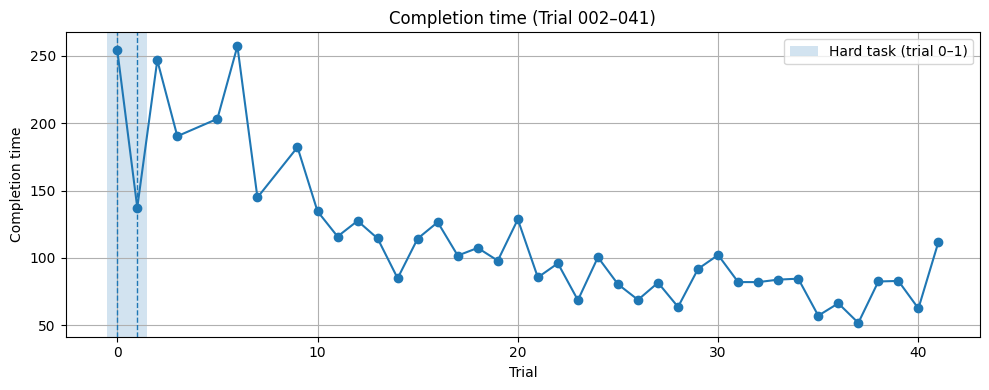

In [24]:
ts["trial"] = pd.to_numeric(ts["trial"], errors="coerce")
ts["start_time"] = pd.to_numeric(ts["start_time"], errors="coerce")
ts["end_time"]   = pd.to_numeric(ts["end_time"], errors="coerce")

# 2) compute completion time (seconds, if your ros_time is in seconds)
ts["completion_time"] = ts["end_time"] - ts["start_time"]

# 3) filter trials 002~041  -> 2~41
ts_2_41 = ts[(ts["trial"] >= 0) & (ts["trial"] <= 41)].copy()
ts_2_41 = ts_2_41.dropna(subset=["completion_time"]).sort_values("trial")

# optional: save
# ts_2_41.to_csv("completion_time_trial002_041.csv", index=False)

# 4) plot
fig, ax = plt.subplots(figsize=(10,4))

ax.axvspan(-0.5, 1.5, alpha=0.2, label="Hard task (trial 0–1)")

ax.plot(ts_2_41["trial"], ts_2_41["completion_time"], marker="o")
ax.set_xlabel("Trial")
ax.set_ylabel("Completion time")
ax.set_title("Completion time (Trial 002–041)")
ax.grid(True)
ax.axvline(0, linestyle="--", linewidth=1)
ax.axvline(1, linestyle="--", linewidth=1)
ax.legend()
plt.tight_layout()
plt.show()


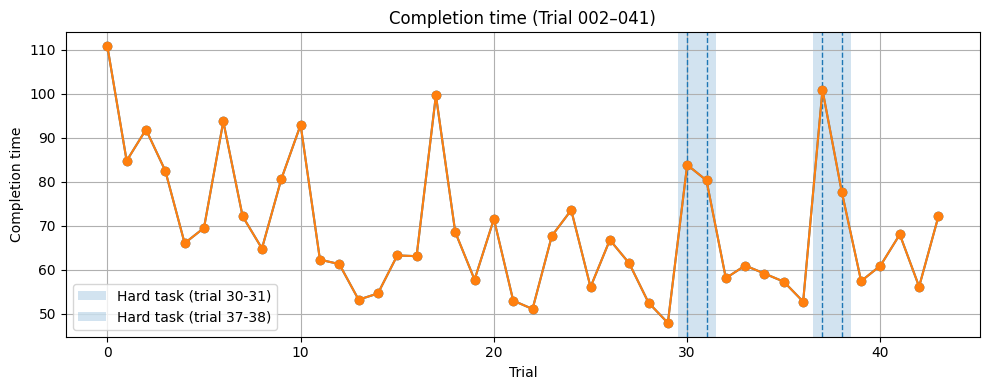

In [30]:
ts2["trial"] = pd.to_numeric(ts2["trial"], errors="coerce")
ts2["start_time"] = pd.to_numeric(ts2["start_time"], errors="coerce")
ts2["end_time"]   = pd.to_numeric(ts2["end_time"], errors="coerce")

# 2) compute completion time (seconds, if your ros_time is in seconds)
ts2["completion_time"] = ts2["end_time"] - ts2["start_time"]

# 3) filter trials 002~041  -> 2~41
ts2_2_41 = ts2[(ts2["trial"] >= 0) & (ts2["trial"] <= 43)].copy()
ts2_2_41 = ts2_2_41.dropna(subset=["completion_time"]).sort_values("trial")

# optional: save
# ts2_2_41.to_csv("completion_time_trial002_041.csv", index=False)
# 4) plot
fig, ax = plt.subplots(figsize=(10,4))

ax.axvspan(29.5, 31.5, alpha=0.2, label="Hard task (trial 30-31)")

ax.axvspan(36.5, 38.5, alpha=0.2, label="Hard task (trial 37-38)")

ax.plot(ts2_2_41["trial"], ts2_2_41["completion_time"], marker="o")
ax.set_xlabel("Trial")
ax.set_ylabel("Completion time")
ax.set_title("Completion time (Trial 002–041)")
ax.grid(True)
ax.axvline(30, linestyle="--", linewidth=1)
ax.axvline(31, linestyle="--", linewidth=1)
ax.axvline(37, linestyle="--", linewidth=1)
ax.axvline(38, linestyle="--", linewidth=1)

ax.legend()
plt.plot(ts2_2_41["trial"], ts2_2_41["completion_time"], marker="o")
plt.xlabel("Trial")
plt.ylabel("Completion time")
plt.title("Completion time (Trial 002–041)")
plt.grid(True)
plt.tight_layout()
plt.show()



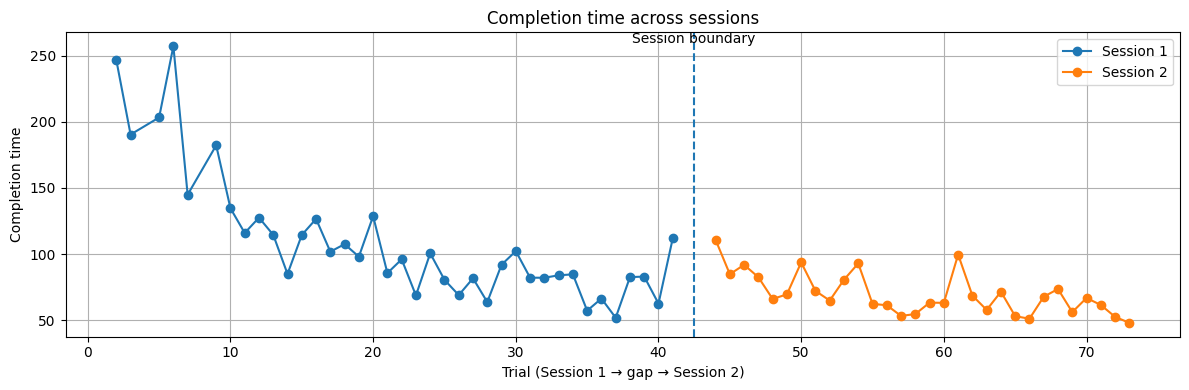

In [9]:
ts_2_41  = ts_2_41.sort_values("trial").copy()
ts2_2_41 = ts2_2_41.sort_values("trial").copy()

# 1) Build "global trial index" with a visible gap
gap = 3  # how many empty trial units you want between sessions

x1 = ts_2_41["trial"].to_numpy()
y1 = ts_2_41["completion_time"].to_numpy()

end1 = np.nanmax(x1)  # last trial number in session 1

x2 = ts2_2_41["trial"].to_numpy()
y2 = ts2_2_41["completion_time"].to_numpy()

# shift session 2 to start after session 1 (+gap)
x2_shift = x2 + end1 + gap

# 2) Plot
plt.figure(figsize=(12,4))
plt.plot(x1, y1, marker="o", label="Session 1")
plt.plot(x2_shift, y2, marker="o", label="Session 2")

# 3) Visual boundary marker + label
boundary_x = end1 + gap/2
plt.axvline(end1 + gap/2, linestyle="--")
plt.text(end1 + gap/2, plt.ylim()[1], "Session boundary", va="top", ha="center")

plt.xlabel("Trial (Session 1 → gap → Session 2)")
plt.ylabel("Completion time")
plt.title("Completion time across sessions")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
